# Comparisons between responses, movie-wise

Movie-wise timecourse comparisons between yes, no and unsure responders, earliest timepoint at which responses diverge for each node - plotted across the brain, node timecourses..

In [1]:
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
s=16
plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [3]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", 
            "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]


In [4]:
#loading shen atlas labels
pd.set_option('display.max_colwidth', None) # so columns are not snipped

# loading the Shen atlas labels
shen268 = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268.head()

1  \
0  {'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}   

                                                                                                                                            2  \
0  {'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}   

                                                                                                                                          3  \
0  {'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}   

                                                                                                                                        4  \
0  {'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}   

                                                                                                                                                                                                            5  \
0  {'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}   

                                                                                                        6  \
0  {'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}   

                                                                                                         7  \
0  {'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}   

                                                                                                         8  \
0  {'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}   

                                                                                                         9  \
0  {'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}   

                                                                                                                                                     10  \
0  {'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}   

   ...  \
0  ...   

                                                                                                                                                                                                                              259  \
0  {'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}   

                                                                                                                                                            260  \
0  {'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}   

                                                                                                        261  \
0  {'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}   

                                                                                                                                             262  \
0  {'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}   

                                                                 

In [5]:
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses.shape

(1049, 10)

### Earliest point of divergence

In [6]:
def responses_ttest(movie_tc, responses, comparison_type = 0,thr=.05, plot_fig =0):
    #This function performs an unpaired t-test between yes and no for each timepoint of a
    # single node and movie
    
    allresp = responses[:,movie_ind]
    resp_yes = allresp==1
    resp_no  = allresp==0
    resp_unsure = allresp==9
    
    if comparison_type == 0: #  yes vs. no
        v1 = resp_yes
        v2 = resp_no
        cols = ['r','b']
    elif comparison_type == 1:  #  yes vs. unsure
        v1 = resp_yes
        v2 = resp_unsure
        cols = ['r','g']
    elif comparison_type == 2:  #  unsure vs. no
        v1 = resp_unsure
        v2 = resp_no
        cols = ['g','b']
    
    nt = movie_tc.shape[1]
    
    tscore = np.empty((nt,))
    tscore[:] = np.nan
    
    pval = np.empty((nt,))
    pval[:] = np.nan
    
    for imno in np.arange(3,nt-1): #time
        tscore[imno],pval[imno] = stats.ttest_ind(movie_tc[v1,imno],movie_tc[v2,imno],equal_var = False,nan_policy='omit')
        
    ts = [np.where(pval[3:] < thr)[0], np.sign(tscore[np.where(pval[3:] < thr)[0]])]
    
    if plot_fig:
        plt.errorbar(np.arange(nt),np.nanmedian(movie_tc[v1,:],axis=0),
                     stats.sem(movie_tc[v1,:],axis=0,nan_policy='omit'),color = cols[0])
        plt.errorbar(np.arange(nt),np.nanmedian(movie_tc[v2,:],axis=0),
                     stats.sem(movie_tc[v2,:],axis=0,nan_policy='omit'),color = cols[1])
    
    ts = [np.where(pval[3:] < thr)[0], np.sign(tscore[np.where(pval[3:] < thr)[0]])]
    
    if plot_fig:
        ymin,ymax = plt.ylim()
        plt.plot(ts[0]+3,np.repeat(1.1*ymax,len(ts[0])),color = 'magenta',marker = '*',ls = 'none')
        plt.vlines(3,ymin,ymax,color = 'grey')
        plt.hlines(0,0,32,color ='grey')
        plt.xticks(np.arange(0,32,6),[str(i) for i in np.arange(-3,28,6)])
                 
    return ts
                 

plotting Random mechanical. Errorbars show sem around median per node...


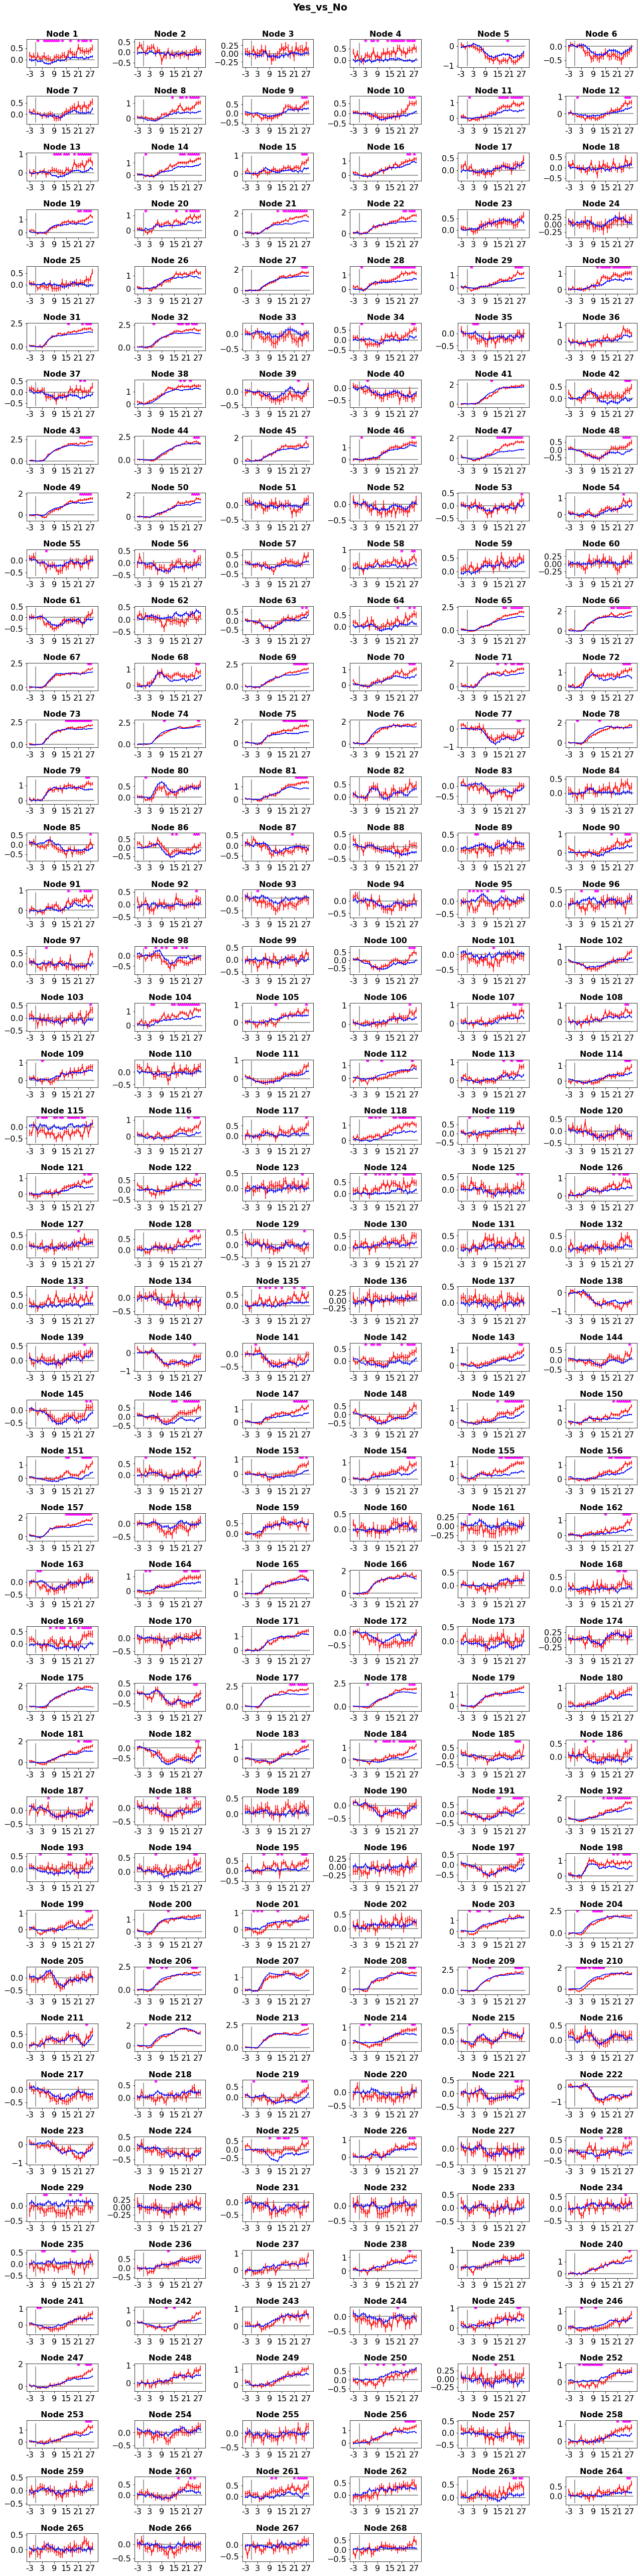

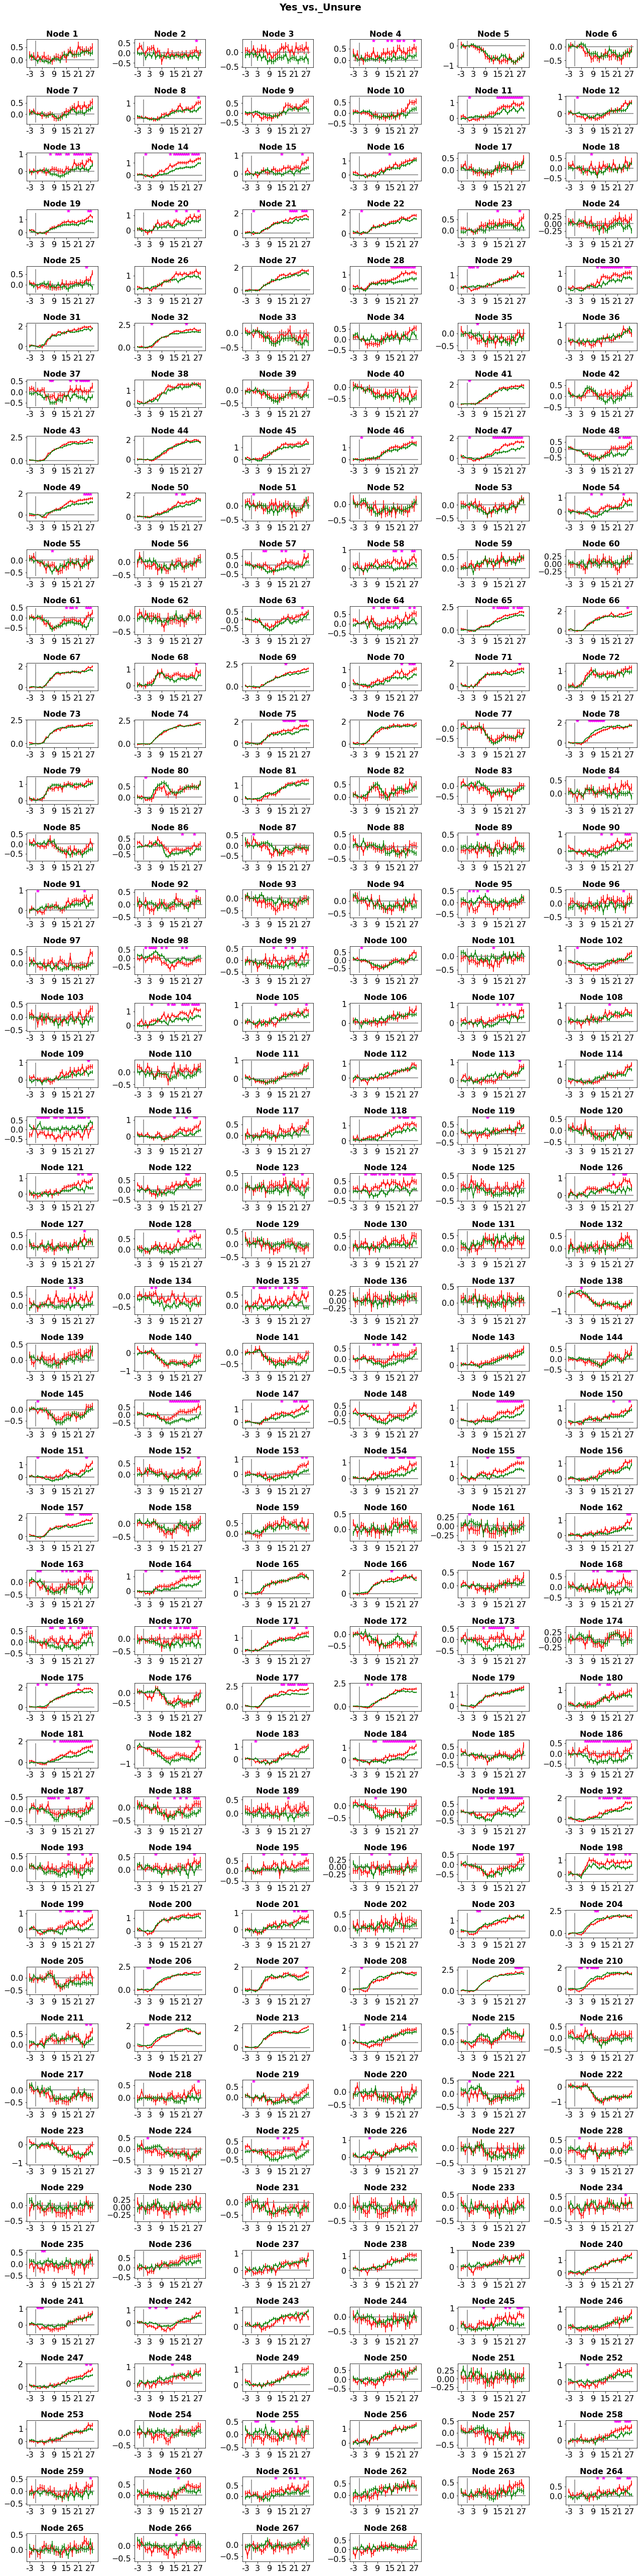

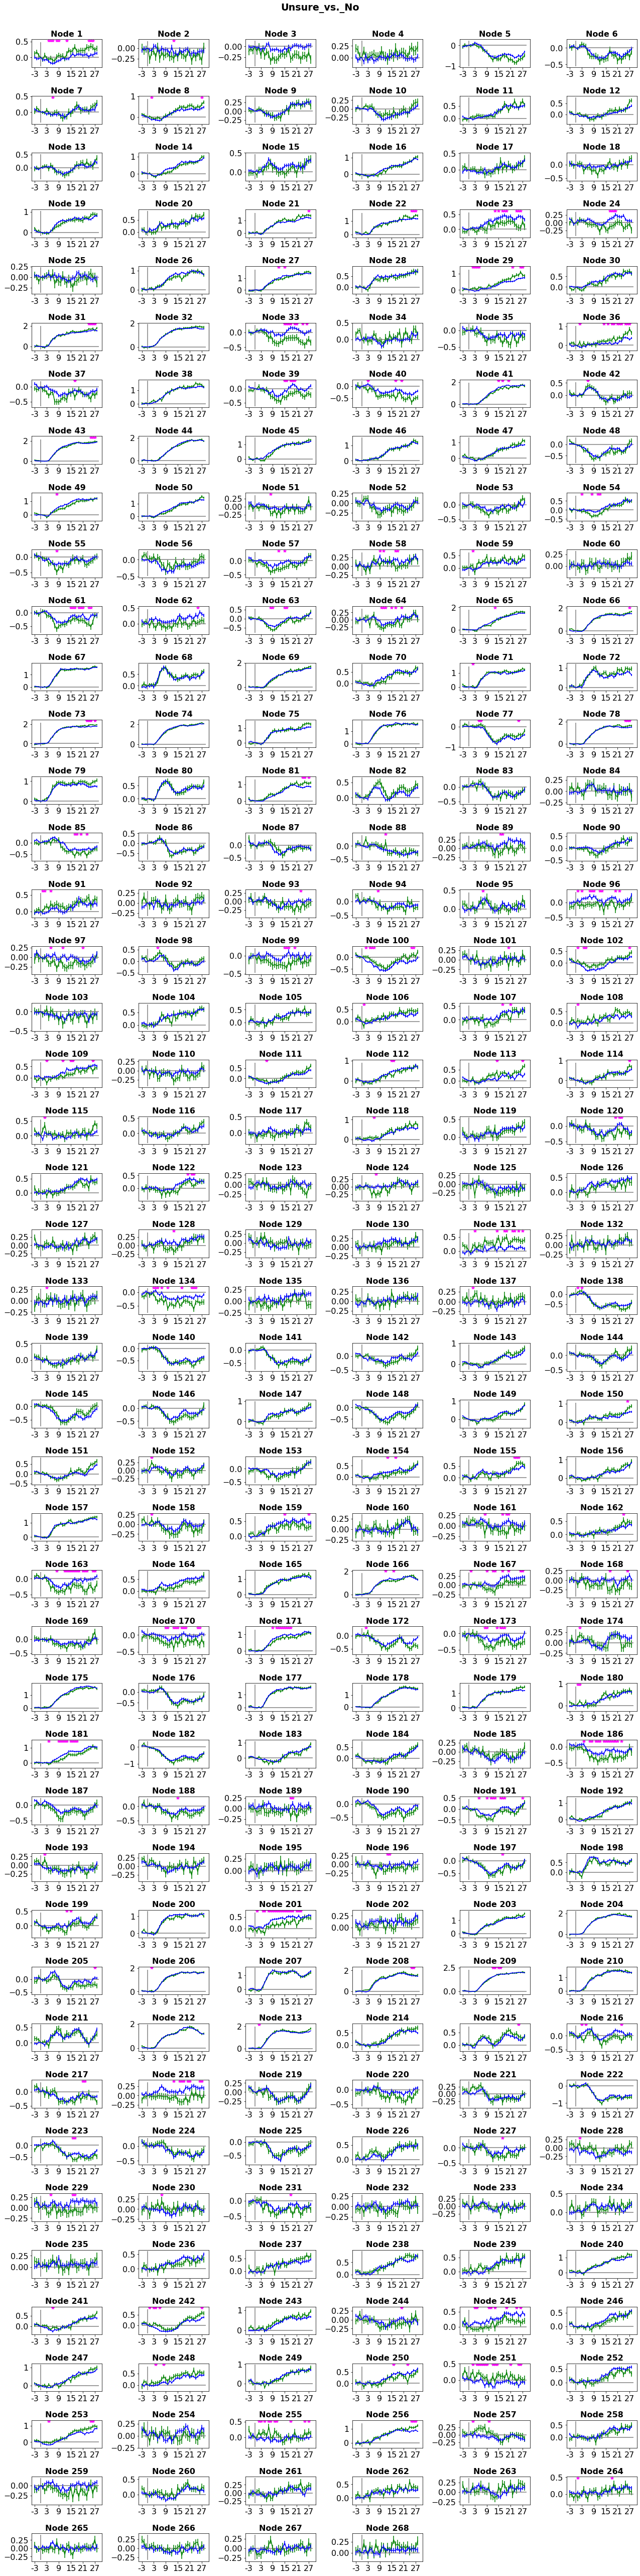

In [7]:
fileName = os.path.join(data_file_loc,'timecourses_run_norm','timecourse-all-movies.npy')
tc_all = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
movie_ind = 4
print(f'plotting {vidnames [movie_ind]}. Errorbars show sem around median per node...')
thr = .05
ts_all = []
earliest_pt = np.empty((268,3))
sign_earliest_pt = np.empty_like(earliest_pt)
plot_fig = 1

for comparisons_type in range(3):
# comparisons_type = 0 # 0: yes vs. no,1: yes vs. unsure, 2: no vs. unsure
   
    if plot_fig == 1:
        ncols=6
        nrows = 45
        #nrows = int(np.ceil(len(sig_nodes)/ncols))

        xwidth = 18
        yheight = .55*nrows*xwidth/ncols
        fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = False, figsize = (xwidth,yheight))
        fig.set_figwidth(xwidth)
        fig.set_figheight(yheight)

        
    nodes = np.arange(0,268)# np.arange(10)
    ts = [] # 268 elements

    for i_nodes,n in enumerate(nodes):

        movieTC = tc_all[:,n,:,movie_ind] # nsubs * nnodes * ntimepts
        if plot_fig:
            plt.subplot(nrows,ncols,i_nodes+1)
            plt.title('Node '+ str(n+1),fontweight = 'bold')
        
        t_array = responses_ttest(movieTC, responses,comparisons_type,thr, plot_fig) # values in [0,28]
        ts.append(t_array)
        #print(t_array)
        earliest_pt[n,comparisons_type] = t_array[0][0] if len(t_array[0])>0 else np.nan
        # first ind of the 1st list element (second is sign)
        sign_earliest_pt[n,comparisons_type] = t_array[1][0] if len(t_array[0])>0 else np.nan
        
    if plot_fig:
        for i_nodes in np.arange(len(nodes),int(nrows*ncols)):
            plt.subplot(nrows,ncols,i_nodes+1)
            plt.axis('off')
        
        if comparisons_type == 0:
            txt = 'Yes_vs_No'
        elif comparisons_type == 1:
            txt = 'Yes_vs._Unsure'
        elif comparisons_type == 2:
            txt = 'Unsure_vs._No'

        plt.suptitle(txt,fontweight='bold')
        
        fig.tight_layout(rect=[0, 0.02, 1, 0.98])
        #plt.tight_layout()
    
    ts_all.append(ts)#3-elements
    if plot_fig:
        plt.savefig(os.path.join(data_file_loc,'figures','timecourses',txt+vidnames[movie_ind][:4]+'.png'))
    

## Plot earliest point on brain map

In [9]:
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nilearn.plotting import plot_glass_brain
import nibabel as nib

lbl = [str.upper(x[0:4]) for x in vidnames]
#lbl

### Magnitudes and  directions

/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

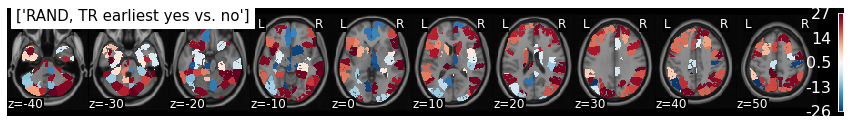

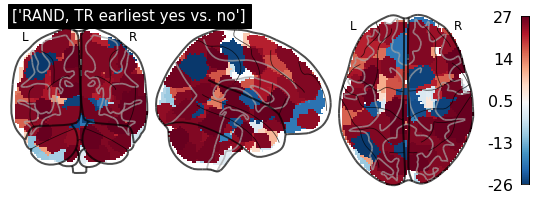

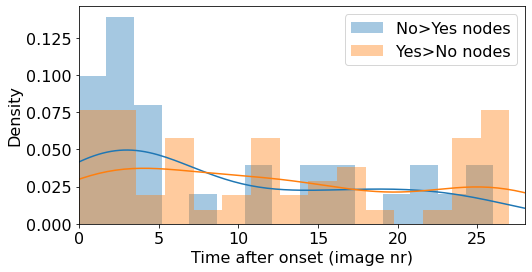

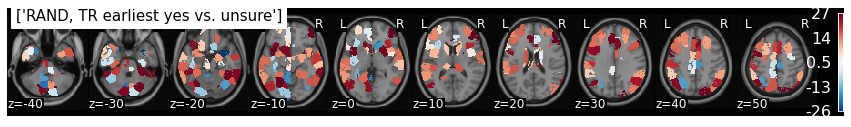

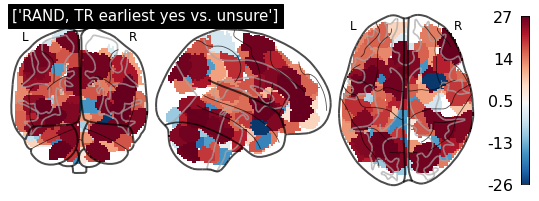

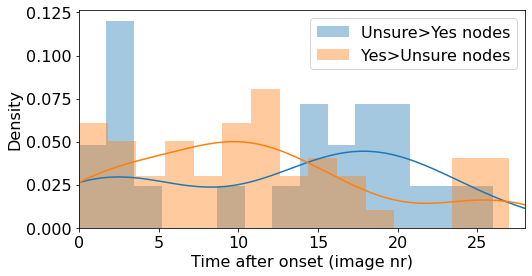

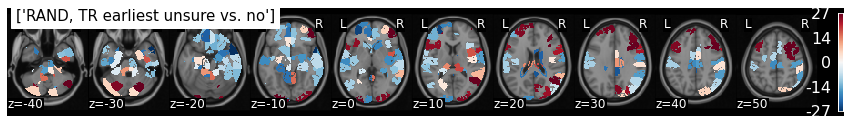

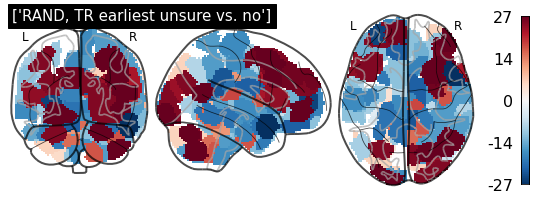

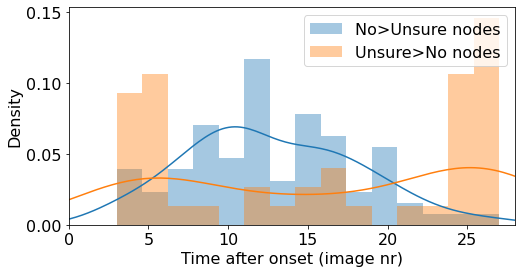

In [12]:
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

img = roi_to_brain(pd.Series(earliest_pt[:,0]*sign_earliest_pt[:,0]), mask_x)
img.plot(colorbar=True, title = [lbl[movie_ind]+', TR earliest yes vs. no'], 
         symmetric_cbar = False,cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(),title = [lbl[movie_ind]+', TR earliest yes vs. no'],
                         symmetric_cbar = False,cmap = 'RdBu_r',colorbar = True, plot_abs=False)

img.write(os.path.join(data_file_loc,'figures',\
                       lbl[movie_ind]+'_earliest_divergence_yes_vs_no.nii'))


plt.figure(3,figsize = (8,4))
sns.distplot(earliest_pt[sign_earliest_pt[:,0] < 0,2], bins = 15, label = 'No>Yes nodes', norm_hist = False)
sns.distplot(earliest_pt[sign_earliest_pt[:,0] > 0,2], bins = 15, label = 'Yes>No nodes', norm_hist = False)
plt.xlabel('Time after onset (image nr)')
plt.xlim(0,28)
plt.legend()



img = roi_to_brain(pd.Series(earliest_pt[:,1]*sign_earliest_pt[:,1]), mask_x)
img.plot(colorbar=True, title = [lbl[movie_ind]+', TR earliest yes vs. unsure'], 
         symmetric_cbar = False,cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(),title = [lbl[movie_ind]+', TR earliest yes vs. unsure'],
                         symmetric_cbar = False,cmap = 'RdBu_r',colorbar = True, plot_abs=False)

img.write(os.path.join(data_file_loc,'figures',\
                       lbl[movie_ind]+'_earliest_divergence_yes_vs_unsure.nii'))

plt.figure(6,figsize = (8,4))
sns.distplot(earliest_pt[sign_earliest_pt[:,1] < 0,2], bins = 15, label = 'Unsure>Yes nodes', norm_hist = False)
sns.distplot(earliest_pt[sign_earliest_pt[:,1] > 0,2], bins = 15, label = 'Yes>Unsure nodes', norm_hist = False)
plt.xlabel('Time after onset (image nr)')
plt.xlim(0,28)
plt.legend()


img = roi_to_brain(pd.Series(earliest_pt[:,2]*sign_earliest_pt[:,2]), mask_x)
img.plot(colorbar=True, title = [lbl[movie_ind]+', TR earliest unsure vs. no'], 
         symmetric_cbar = False,cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(),title = [lbl[movie_ind]+', TR earliest unsure vs. no'],
                         symmetric_cbar = False,cmap = 'RdBu_r',colorbar = True, plot_abs=False)

img.write(os.path.join(data_file_loc,'figures',\
                       lbl[movie_ind]+'_earliest_divergence_no_vs_unsure.nii'))
plt.figure(9,figsize = (8,4))
sns.distplot(earliest_pt[sign_earliest_pt[:,2] < 0,2], bins = 15, label = 'No>Unsure nodes', norm_hist = False)
sns.distplot(earliest_pt[sign_earliest_pt[:,2] > 0,2], bins = 15, label = 'Unsure>No nodes', norm_hist = False)
plt.xlabel('Time after onset (image nr)')
plt.xlim(0,28)
plt.legend()



### Only magnitudes

"plt.figure(7,figsize = (4,4))\nsns.distplot(np.abs(signodes[signodes<0]), bins= 15, label = 'No>Yes nodes', norm_hist = False)\nsns.distplot(signodes[signodes>0], bins= 15, label = 'Yes>No nodes', norm_hist = False)\nplt.xlabel('Time after onset (image nr)')\nplt.xlim(0,28)\nplt.legend()"

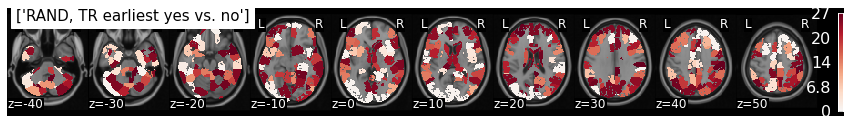

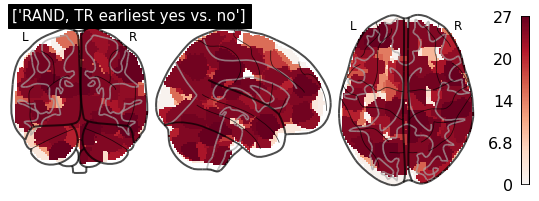

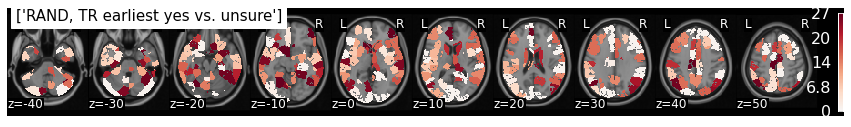

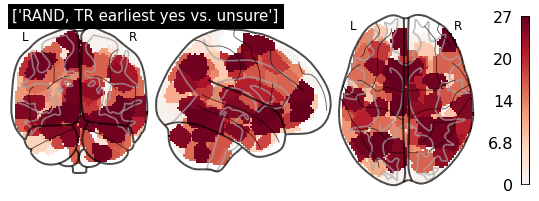

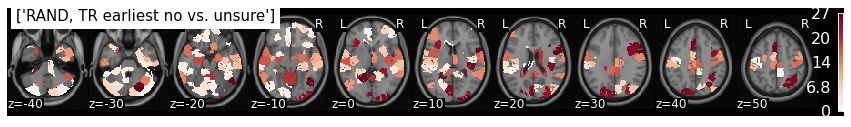

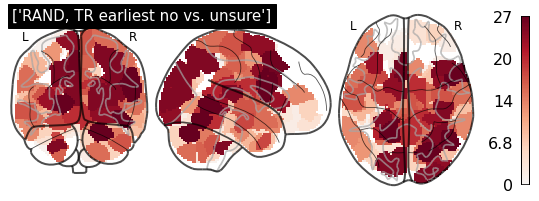

In [10]:
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

img = roi_to_brain(pd.Series(earliest_pt[:,0]), mask_x)
img.plot(colorbar=True, title = [lbl[movie_ind]+', TR earliest yes vs. no'], 
         symmetric_cbar = False,cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(),title = [lbl[movie_ind]+', TR earliest yes vs. no'],
                         symmetric_cbar = False,cmap = 'RdBu_r',colorbar = True, plot_abs=False)

img.write(os.path.join(data_file_loc,'figures',\
                       lbl[movie_ind]+'_earliest_divergence_yes_vs_no.nii'))


img = roi_to_brain(pd.Series(earliest_pt[:,1]), mask_x)
img.plot(colorbar=True, title = [lbl[movie_ind]+', TR earliest yes vs. unsure'], 
         symmetric_cbar = False,cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(),title = [lbl[movie_ind]+', TR earliest yes vs. unsure'],
                         symmetric_cbar = False,cmap = 'RdBu_r',colorbar = True, plot_abs=False)

img.write(os.path.join(data_file_loc,'figures',\
                       lbl[movie_ind]+'_earliest_divergence_yes_vs_unsure.nii'))


img = roi_to_brain(pd.Series(earliest_pt[:,2]), mask_x)
img.plot(colorbar=True, title = [lbl[movie_ind]+', TR earliest no vs. unsure'], 
         symmetric_cbar = False,cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(),title = [lbl[movie_ind]+', TR earliest no vs. unsure'],
                         symmetric_cbar = False,cmap = 'RdBu_r',colorbar = True, plot_abs=False)

img.write(os.path.join(data_file_loc,'figures',\
                       lbl[movie_ind]+'_earliest_divergence_no_vs_unsure.nii'))

'''plt.figure(7,figsize = (4,4))
sns.distplot(np.abs(signodes[signodes<0]), bins= 15, label = 'No>Yes nodes', norm_hist = False)
sns.distplot(signodes[signodes>0], bins= 15, label = 'Yes>No nodes', norm_hist = False)
plt.xlabel('Time after onset (image nr)')
plt.xlim(0,28)
plt.legend()'''

In [21]:
earliest_pt

array([[ 1., nan,  4.],
       [nan, 26., 13.],
       [nan, nan, nan],
       [ 3.,  7., nan],
       [20., nan, nan],
       [nan, nan, nan],
       [nan, nan,  6.],
       [14., 27.,  2.],
       [25., nan, nan],
       [25., nan, nan],
       [ 1.,  1., nan],
       [ 1.,  1., nan],
       [ 9.,  7., nan],
       [ 1.,  1., nan],
       [25., 15., nan],
       [24., 15., nan],
       [nan, nan, nan],
       [nan,  8., nan],
       [21., 16., nan],
       [ 1., 16., nan],
       [13.,  1., 27.],
       [22.,  1., 25.],
       [nan, 15., 13.],
       [nan, nan, 17.],
       [nan, 25., nan],
       [nan, nan, nan],
       [25., nan, 12.],
       [ 1., 16., nan],
       [ 2.,  1.,  2.],
       [11., 11., nan],
       [16., nan, 24.],
       [ 5.,  4., nan],
       [25., nan, 15.],
       [ 1., nan, nan],
       [ 3.,  5., nan],
       [nan, nan,  2.],
       [22.,  7., 17.],
       [18., nan, nan],
       [23., nan, 15.],
       [ 4., nan,  3.],
       [12.,  1., 15.],
       [25., nan

In [20]:
np.where(earliest_pt[:,0] <=2)[0]

array([  0,  10,  11,  13,  19,  27,  28,  33,  45,  77,  79,  94,  97,
       114, 118, 140, 151, 160, 162, 163, 192, 200, 202, 203, 205, 208,
       209, 211, 213, 214, 218, 240, 251])

## Identifying and plotting timecourses of specific nodes/ROIs

In [49]:
tc1.shape

(88, 32)

Node label: 92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex


<function matplotlib.pyplot.hlines(y, xmin, xmax, colors=None, linestyles='solid', label='', *, data=None, **kwargs)>

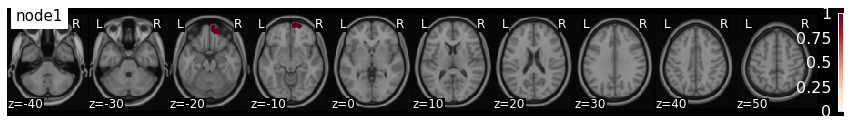

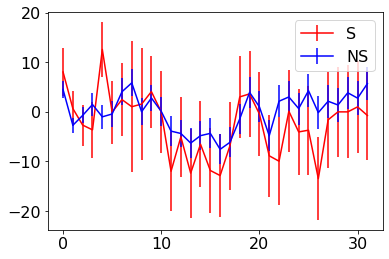

In [50]:
from plot_roi_tc import plot_roi_tc

n = 2
movie_ind = 4

movieTC = tc_all[:,n,:,movie_ind]
yes_resp = responses[:,movie_ind] == 1
no_resp = responses[:,movie_ind] == 0
unsure_resp = responses[:,movie_ind] == 9

tc1 = movieTC[yes_resp,:]
tc2 = movieTC[no_resp,:]
node_ind = 0
plot_roi_tc(tc1,tc2,node_ind,data_file_loc,['r','b'],['S','NS'])
plt.figure(1)
plt.hlines

In [44]:
nodes = np.where(np.abs(earliest_pt[:,0])==0)[0]
dict1 = ["" for x in range(len(nodes))]
for i,n in enumerate(nodes):
    dict1[i] = eval(shen268[str(n +1)][0])['name']
    #print(n,dict1,'\n')
    
df = pd.DataFrame({'nodes:':nodes,'timepts:':earliest_pt[nodes,0],'labels': dict1})
df.head(50)



nodes:  timepts:  \
0        0       0.0   
1        3       0.0   
2       16       0.0   
3       27       0.0   
4       37       0.0   
5       76       0.0   
6       85       0.0   
7      114       0.0   
8      117       0.0   
9      151       0.0   
10     167       0.0   
11     172       0.0   
12     179       0.0   
13     224       0.0   

                                                                                                                                                                            labels  
0                                                                                                                                 92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex  
1                                                                                                                               54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex  
2                                                                                                                               66.67% Frontal_Pole; 32.63% Frontal_Orbital_Cortex  
3   41.56% Paracingulate_Gyrus; 27.43% Superior_Frontal_Gyrus; 21.52% Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex); 9.49% Cingulate_Gyrus_anterior_division  
4                                                                                                                        57.66% Superior_Parietal_Lobule; 36.57% Postcentral_Gyrus  
5                                                                         70.63% Cuneal_Cortex; 15.55% Precuneous_Cortex; 7.49% Intracalcarine_Cortex; 6.33% Supracalcarine_Cortex  
6                                                                                                               85.29% Precuneous_Cortex; 6.70% Cingulate_Gyrus_posterior_division  
7                                                                                                                                               81.17% no_label; 18.83% Brain-Stem  
8                                                                                                                                                                 100.00% no_label  
9                                                                                                                               54.11% Frontal_Orbital_Cortex; 45.89% Frontal_Pole  
10                                                                                          47.36% Central_Opercular_Cortex; 42.27% Insular_Cortex; 8.02% Frontal_Operculum_Cortex  
11                                                                               59.09% Central_Opercular_Cortex; 31.36% Insular_Cortex; 9.55% Heschl's_Gyrus_(includes_H1_and_H2)  
12                                                     48.72% Parietal_Operculum_Cortex; 30.11% Planum_Temporale; 14.60% Heschl's_Gyrus_(includes_H1_and_H2); 5.66% Insular_Cortex  
13                                                                                                             74.46% Precuneous_Cortex; 25.38% Cingulate_Gyrus_posterior_division

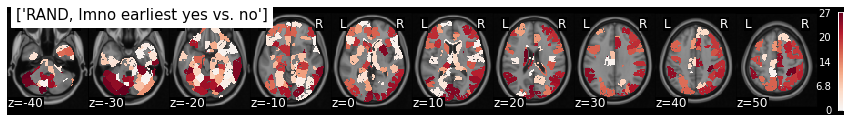

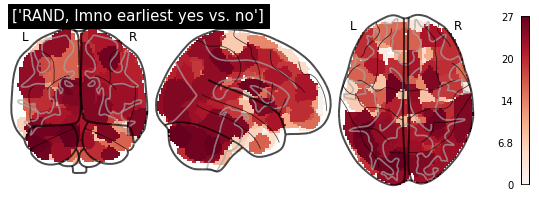

In [16]:
#plot only based on magnitude
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

timepts_signed = max_timept_yes_min_no[:,0]*np.sign(max_timept_yes_min_no[:,1])
#print(timepts_signed)
#timepts_signed[abs(timepts_signed)<=3] =0 # since too early differences are not stimulus induced
# EVEN BETTER: implement 3 as the floor value while finding the earliest divergence pt
#print(timepts_signed)
img = roi_to_brain(pd.Series(np.abs(timepts_signed)), mask_x) # plot max difference timepoint for each node
# red/blue indicate whether yes>no or yes-no at that timept >0 or <0
# intensity of red/blue indicate whether the activity was early or late 
#(todo: change negative values in the colorbar)


img.plot(colorbar=True, title = [lbl[movie_ind]+', Imno earliest yes vs. no'], 
         symmetric_cbar = False,cmap = 'RdBu_r')

plot_glass_brain(img.to_nifti(),title = [lbl[movie_ind]+', Imno earliest yes vs. no'],
                         symmetric_cbar = False,cmap = 'RdBu_r',colorbar = True, plot_abs=False)
    
img.write(os.path.join(data_file_loc,'figures',\
                       'RAND_earliest_divergence_yes_vs.no_unsigned.nii'))




/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


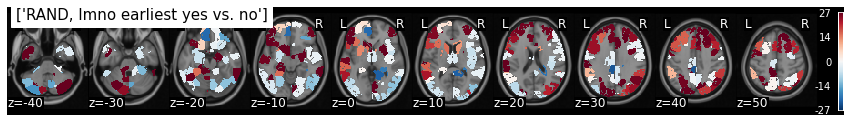

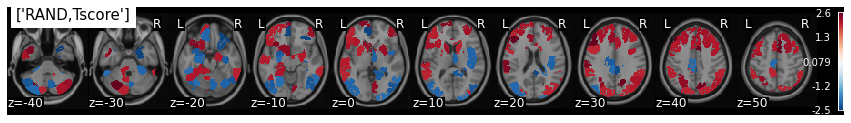

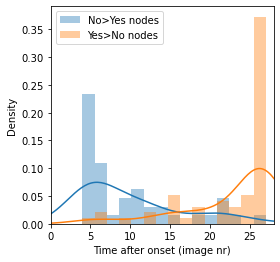

In [29]:

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
timepts_signed = max_timept_yes_min_no[:,0]*np.sign(max_timept_yes_min_no[:,1])
#print(timepts_signed)
#timepts_signed[abs(timepts_signed)<=3] =0 # since too early differences are not stimulus induced
# EVEN BETTER: implement 3 as the floor value while finding the earliest divergence pt
#print(timepts_signed)
img = roi_to_brain(pd.Series(timepts_signed), mask_x) # plot max difference timepoint for each node
# red/blue indicate whether yes>no or yes-no at that timept >0 or <0
# intensity of red/blue indicate whether the activity was early or late 
#(todo: change negative values in the colorbar)
img.plot(colorbar=True, title = [lbl[movie_ind]+', Imno earliest yes vs. no'], symmetric_cbar = False,cmap = 'RdBu_r')

tscore = max_timept_yes_min_no[:,1]
tscore[abs(timepts_signed)<=3] =0
img = roi_to_brain(pd.Series(tscore), mask_x)
img.plot(colorbar=True, title = [lbl[movie_ind]+',Tscore'], cmap = 'RdBu_r',symmetric_cbar = False)


signodes = max_timept_yes_min_no[:,0]*np.sign(max_timept_yes_min_no[:,1]) # earliest timept * direction (+1 or -1)
earliest_ = np.where(np.abs(signodes) == np.min(np.abs(signodes)))[0]
latest_ = np.where(np.abs(signodes) == np.max(np.abs(signodes)))[0]

plt.figure(3,figsize = (4,4))
sns.distplot(np.abs(signodes[signodes<0]), bins= 15, label = 'No>Yes nodes', norm_hist = False)
sns.distplot(signodes[signodes>0], bins= 15, label = 'Yes>No nodes', norm_hist = False)
plt.xlabel('Time after onset (image nr)')
plt.xlim(0,28)
plt.legend()

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


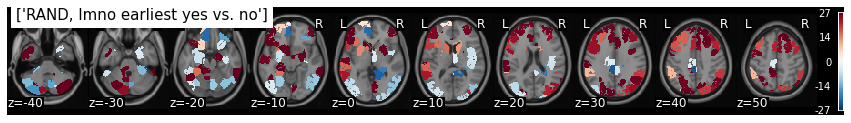

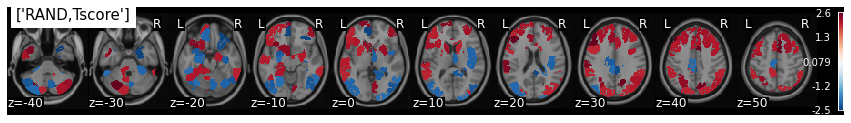

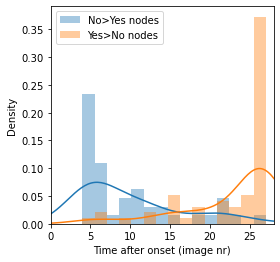

In [36]:
movie_ind = 4

max_timept_yes, max_timept_no, max_timept_yes_min_no, tscores, pvals = max_timepoints_nodes(movie_ind,responses_slopereg)

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
timepts_signed = max_timept_yes_min_no[:,0]*np.sign(max_timept_yes_min_no[:,1])
#print(timepts_signed)
timepts_signed[abs(timepts_signed)<=3] =0 # since too early differences are not stimulus induced
# EVEN BETTER: implement 3 as the floor value while finding the earliest divergence pt
#print(timepts_signed)
img = roi_to_brain(pd.Series(timepts_signed), mask_x) # plot max difference timepoint for each node
# red/blue indicate whether yes>no or yes-no at that timept >0 or <0
# intensity of red/blue indicate whether the activity was early or late 
#(todo: change negative values in the colorbar)
img.plot(colorbar=True, title = [lbl[movie_ind]+', Imno earliest yes vs. no'], symmetric_cbar = False,cmap = 'RdBu_r')

tscore = max_timept_yes_min_no[:,1]
tscore[abs(timepts_signed)<=3] =0
img = roi_to_brain(pd.Series(tscore), mask_x)
img.plot(colorbar=True, title = [lbl[movie_ind]+',Tscore'], cmap = 'RdBu_r',symmetric_cbar = False)


signodes = max_timept_yes_min_no[:,0]*np.sign(max_timept_yes_min_no[:,1]) # earliest timept * direction (+1 or -1)
earliest_ = np.where(np.abs(signodes) == np.min(np.abs(signodes)))[0]
latest_ = np.where(np.abs(signodes) == np.max(np.abs(signodes)))[0]

plt.figure(3,figsize = (4,4))
sns.distplot(np.abs(signodes[signodes<0]), bins= 15, label = 'No>Yes nodes', norm_hist = False)
sns.distplot(signodes[signodes>0], bins= 15, label = 'Yes>No nodes', norm_hist = False)
plt.xlabel('Time after onset (image nr)')
plt.xlim(0,28)
plt.legend()

In [17]:
labels = pd.read_csv('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/shen_roi_info_files/xilin_268parc_labels.csv')
#labels

list_temp = ['gui_Lobes','gui_BrodLabels','gui_Networks']
roi_breakdown = {}
for n in list_temp:
    roi_breakdown[n] = []
    
roi_breakdown['gui_Lobes'] = {
1: 'R-Prefrontal',
2: 'R-MotorStrip',  3: 'R-Insula',
4: 'R-Parietal',    5: 'R-Temporal',
6: 'R-Occipital',   7: 'R-Limbic',
8: 'R-Cerebellum',  9: 'R-Subcortical',
10: 'R-Brainstem', 11: 'L-Prefrontal',
12: 'L-MotorStrip',13: 'L-Insula',
14: 'L-Parietal',  15: 'L-Temporal',
16: 'L-Occipital', 17: 'L-Limbic',
18: 'L-Cerebellum',19: 'L-Subcortical',
20: 'L-Brainstem' };

roi_breakdown['gui_BrodLabels'] = {1 : 'PrimSensory (1)',   4 : 'PrimMotor (4)',
5 : 'SensoryAssoc (5)',  6 : 'BA6',
7 : 'BA7',              8 : 'BA8',
9 : 'BA9',              10 : 'BA10',
11 : 'BA11',            13 : 'Insula (13)',
14 : 'BA14',            17 : 'PrimVisual (17)',
18 : 'VisualAssoc (18)', 19 : 'BA19',
20 : 'BA20',            21 : 'BA21',
22 : 'BA22',            23 : 'BA23',
24 : 'BA24',            25 : 'BA25',
30 : 'BA30',            31 : 'BA31',
32 : 'BA32',            34 : 'BA34',
36 : 'Parahip (36)',     37 : 'Fusiform (37)',
38 : 'BA38',            39 : 'BA39',
40 : 'BA40',            41 : 'PrimAuditory (41)',
44 : 'BA44',            45 : 'BA45',
46 : 'BA46',            47 : 'BA47',
48 : 'Caudate (48)',     49 : 'Putamen (49)',
50 : 'Thalamus (50)',    51 : 'GlobPal (51)',
52 : 'NucAccumb (52)',   53 : 'Amygdala (53)',
54 : 'Hippocampus (54)', 55 : 'Hypothalamus (55)',
58 : 'BrainStem',        57 : 'Cerebellum',
    };

roi_breakdown['gui_Networks'] ={
1:  'Somato-Motor',
3:  'Cingular-opercular',
4:  'Auditory',
5:  'Default Mode',
7:  'Visual',
8:  'Frontal-Parietal',
9:  'Salience',
10: 'Subcortical',
11: 'Ventral-Attention',
12: 'Dorsal-Attention'}


In [41]:
# to identify the rois
pos_rois = np.where(timepts_signed>0)[0]
neg_rois = np.where(timepts_signed<0)[0]


lobe_list = []
network_list = []
cols = ['ROI', 'Time','Lobe', 'Network', 'BrodLabel', 'Name']
lst = []

pnum = 1
for n in pos_rois:
    val = max_timept_yes_min_no[n,0]
    n += 1 # same as roi
    
    row = np.where(labels['Node_No']==int(n))[0][0]

    Lobe = labels.iloc[row][4]
    Network = labels.iloc[row][6]
    BrodLabel = labels.iloc[row][7]

    try:
        a = roi_breakdown['gui_Lobes'][Lobe]
    except:
        a = Lobe
    try:
        b = roi_breakdown['gui_BrodLabels'][BrodLabel]
    except: 
        b = BrodLabel
    try:
        c = roi_breakdown['gui_Networks'][Network]
    except:
        c = Network
    res = eval(shen268[str(n)][0])
   
    lobe_list.append(a)
    network_list.append(c)

    lst.append([n, val,a, c, b, res['name']])
df1 = pd.DataFrame(lst, columns=cols)
df1 = df1.sort_values(by = 'Time',ascending = True)


df1 = df1.style.set_properties(**{
    'background-color': 'white',
    'font-size': '8pt'})
df1

      



/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


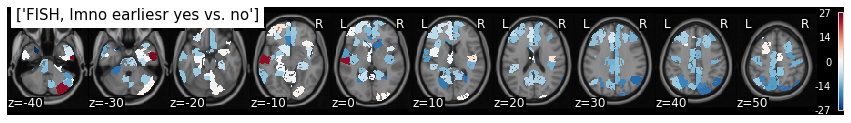

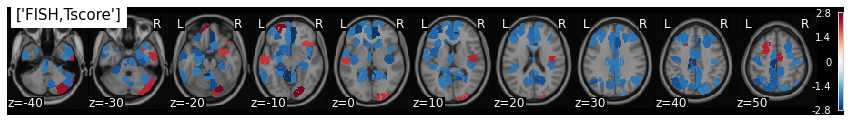

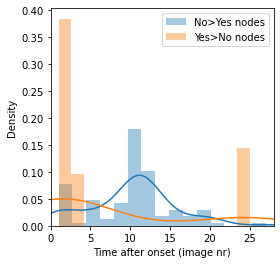

In [56]:
movie_ind = 3

max_timept_yes, max_timept_no, max_timept_yes_min_no, tscores, pvals = max_timepoints_nodes(movie_ind,responses_slopereg)

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
    
img = roi_to_brain(pd.Series(max_timept_yes_min_no[:,0]*np.sign(max_timept_yes_min_no[:,1])), mask_x) # plot max difference timepoint for each node
# red/blue indicate whether yes>no or yes-no at that timept >0 or <0
# intensity of red/blue indicate whether the activity was early or late 
#(todo: change negative values in the colorbar)
img.plot(colorbar=True, title = [lbl[movie_ind]+', Imno earliesr yes vs. no'], cmap = 'RdBu_r')

img = roi_to_brain(pd.Series(max_timept_yes_min_no[:,1]), mask_x)
img.plot(colorbar=True, title = [lbl[movie_ind]+',Tscore'], cmap = 'RdBu_r')



signodes = max_timept_yes_min_no[:,0]*np.sign(max_timept_yes_min_no[:,1]) # earliest timept * direction (+1 or -1)
earliest_ = np.where(np.abs(signodes) == np.min(np.abs(signodes)))[0]
latest_ = np.where(np.abs(signodes) == np.max(np.abs(signodes)))[0]

plt.figure(3,figsize = (4,4))
sns.distplot(np.abs(signodes[signodes<0]), bins= 15, label = 'No>Yes nodes', norm_hist = False)
sns.distplot(signodes[signodes>0], bins= 15, label = 'Yes>No nodes', norm_hist = False)
plt.xlabel('Time after onset (image nr)')
plt.xlim(0,28)
plt.legend()

/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/timecourse-movie3.npy
firstdiff_line: 0.0
maxdiff_line: 0.0
43.55% Frontal_Operculum_Cortex; 33.40% Insular_Cortex; 10.36% Inferior_Frontal_Gyrus_pars_triangularis; 6.98% Frontal_Orbital_Cortex; 5.71% Inferior_Frontal_Gyrus_pars_opercularis


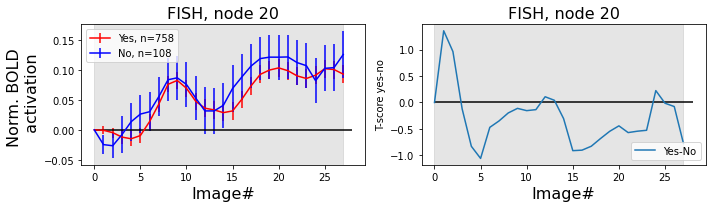

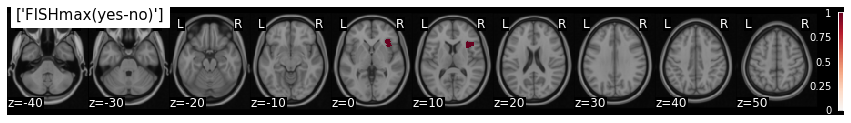

In [422]:
# locating an the ROI on brainmap and timecourses
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
    
movie_ind = 3
fileName = os.path.join(data_file_loc,f'timecourse-movie{movie_ind}.npy')
print(fileName)
movieTC = np.load(fileName) # nsubs * nnodes * ntimepts
movieTC = movieTC[:,:,:28]

node_ind = 19
node = node_ind+1
firstdiff_line = max_timept[node-1,4]
print('firstdiff_line:',firstdiff_line)
maxdiff_line = max_timept[node-1,6]
print('maxdiff_line:',maxdiff_line)
plot_single_node_tc(movie_ind,responses_slopereg, node, movieTC, tscores, firstdiff_line, maxdiff_line) 

# Nodes can be viewed here: https://bioimagesuiteweb.github.io/webapp/connviewer.html
dict = eval(shen268[str(node)][0])
print(dict['name'])

mat = np.zeros((268,))
mat[node-1] = 1
img = roi_to_brain(pd.Series(mat), mask_x) # plot max difference timepoint for each node
# red/blue indicate whether yes>no or yes-no at that timept >0 or <0
# intensity of red/blue indicate whether the activity was early or late 
#(todo: change negative values in the colorbar)
img.plot(colorbar=True, title = [lbl[movie_ind]+'max(yes-no)'], cmap = 'RdBu_r')

number of nodes= 139


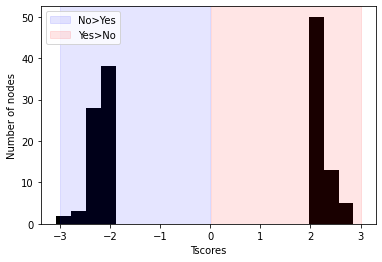

In [319]:
signodes = max_timept[:,4]*np.sign(max_timept[:,5])
plt.hist(max_timept[signodes!=0,5], bins= 20, color = 'k')
print('number of nodes=',len(max_timept[signodes!=0,5]))
plt.ylabel('Number of nodes')
plt.xlabel('Tscores')
plt.axvspan(-3,-0.01, color = 'blue', alpha = .1, label = 'No>Yes')  #vertical shading
plt.axvspan(0.01,3, color = 'red', alpha = .1, label = 'Yes>No')  #vertical shading
plt.legend(loc ='best')

earliest node: 3.0
number of nodes= 131


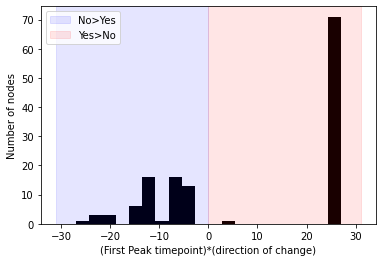

In [235]:
signodes = max_timept[:,6]*np.sign(max_timept[:,7])
signodes = signodes[signodes!=0]
print('earliest node:',np.min(np.abs(signodes)))
print('number of nodes=',len(signodes))
plt.hist(signodes, bins= 20, color = 'k')
plt.ylabel('Number of nodes')
plt.xlabel('(First Peak timepoint)*(direction of change)')
plt.axvspan(-31,-0.01, color = 'blue', alpha = .1, label = 'No>Yes')  #vertical shading
plt.axvspan(0.01,31, color = 'red', alpha = .1, label = 'Yes>No')  #vertical shading
plt.legend(loc ='best')

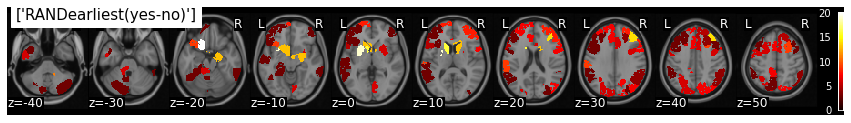

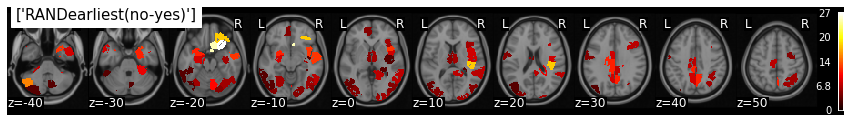

In [237]:
mat = np.zeros_like(max_timept[:,4])
rows = np.where(max_timept[:,5]>0)[0]
mat[rows] = max_timept[rows,2]
img = roi_to_brain(pd.Series(mat), mask_x)
img.plot(colorbar=True, title = [lbl[movie_ind]+'earliest(yes-no)'])

mat = np.zeros_like(max_timept[:,4])
rows = np.where(max_timept[:,5]<0)[0]
mat[rows] = max_timept[rows,2]
img = roi_to_brain(pd.Series(mat), mask_x)
img.plot(colorbar=True, title = [lbl[movie_ind]+'earliest(no-yes)'])

# extra

In [ ]:
#pip install mplcursors
import mplcursors
plt.isinteractive()
#plt.ioff()
#%matplotlib notebook
#%matplotlib widget
%matplotlib inline

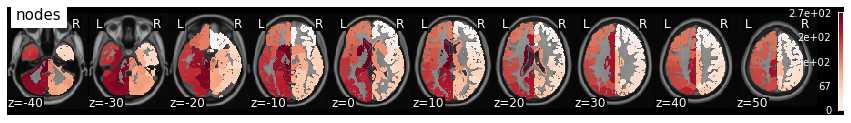

In [239]:
img = roi_to_brain(pd.Series(range(268)), mask_x) # plot max difference timepoint for each node
# red/blue indicate whether yes>no or yes-no at that timept >0 or <0
# intensity of red/blue indicate whether the activity was early or late 
#(todo: change negative values in the colorbar)
img.plot(colorbar=True, title = 'nodes', cmap = 'RdBu_r')
mplcursors.cursor() 

In [ ]:
# Nodes can be viewed here: https://bioimagesuiteweb.github.io/webapp/connviewer.html
for i in range(268):
    dict = eval(shen268[str(i+1)][0])
    if (dict['name'].find('Superior_Temporal_Gyrus_posterior_division') != -1):
        print('node:',i+1, ',name:', dict['name'], '\n')

In [ ]:
### Highest Yes-No difference

# identifying timepts at which yes, no and yes -no show the earliest and 
# highest differences

def max_timepoints_nodes(movie_ind,responses_slopereg):
    #movie_ind = 4
    nt = 28
    
    fileName = os.path.join(data_file_loc,'timecourses_run_norm',\
                            'timecourse-all-movies.npy')
    tc_all = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
    movieTC = tc_all[:,:,3:-1,movie_ind]
        

    #fileName = os.path.join(data_file_loc,f'timecourse-movie{movie_ind}.npy')
    #movieTC = np.load(fileName) # nsubs * nnodes * ntimepts

    allresp = responses_slopereg[:,movie_ind]
    resp_yes = allresp==1
    resp_no = allresp==0
    
    # mean yes-no tscores and pvals at each timept for all nodes
    tscores = np.zeros((268,28)) 
    pvals = np.zeros((268,28))

    max_timept_yes = np.empty((268,4)) # YES: cols: imno 1st sig, tscore 1st sig, imno maxtscore, tscore max 
    max_timept_yes[:]=np.nan
    max_timept_no = np.empty((268,4)) # NO: cols: imno 1st sig, tscore 1st sig, imno maxtscore, tscore max
    max_timept_no[:]=np.nan
    max_timept_yes_min_no = np.empty((268,4)) # YES-NO: cols: imno 1st sig, tscore 1st sig, imno maxtscore, tscore max,
    max_timept_yes_min_no[:]=np.nan
    
    for node in range(268):
        #print('node',node)
        for i in range(3): #yes,no,yes-no
            if i == 0: # yes
                Y = movieTC[resp_yes,node,:nt] # subjects*timepts
            elif i == 1: # no
                Y = movieTC[resp_no,node,:nt] # subjects*timepts
            elif i == 2: #yes-no
                Y1 = movieTC[resp_yes,node,:nt] # subjects*timepts
                Y2 = movieTC[resp_no,node,:nt] # subjects*timepts

            tscore = np.zeros((nt,))
            pval = np.zeros((nt,))
            if i <= 1:
                for im in np.arange(1,nt): # no difference at t=0 since baseline-corrected, hence starting at 1
                    tscore[im],pval[im] = stats.ttest_1samp(Y[:,im],0)
            else:
                for im in np.arange(1,nt): # no difference at t=0 since baseline-corrected, hence starting at 1
                    tscore[im],pval[im] = stats.ttest_ind(Y1[:,im],Y2[:,im], 
                                                          equal_var=False)
                tscores[node,:] = tscore
                pvals[node,:] = pval
                
            df = pd.DataFrame({'imno': np.arange(0,nt),'tscore': tscore,'tscore_mag':np.abs(tscore), 
                               'tscore_sign':np.sign(tscore),'pval':pval})
            #df = df.loc[(df['tscore_mag']!=0) &(df['pval']<=0.05) &(df['imno']>0),:]
            df = df.loc[(df['pval']<=0.05) &(df['imno']>0),:]


            if len(df):
                for itime,cond in enumerate(['earliest','highest_mag']):
                    if cond == 'earliest': # sort by image number
                        df_sorted = df.sort_values(by = 'imno',ascending = True)
                    elif cond == 'highest_mag': # sort by magnitude of differences, i.e., tscore
                        df_sorted = df.sort_values(by = ['tscore_mag','imno'],
                                                   ascending = False)
                    
                    if i == 0: # yes
                        max_timept_yes[node,itime*2] = df_sorted['imno'].values[0]
                        max_timept_yes[node,(itime*2)+1] = df_sorted['tscore'].values[0] 
                    elif i == 1: # no
                        max_timept_no[node,itime*2] = df_sorted['imno'].values[0]
                        max_timept_no[node,(itime*2)+1] = df_sorted['tscore'].values[0] 
                    elif i == 2: # yes-no
                        max_timept_yes_min_no[node,itime*2] = df_sorted['imno'].values[0]
                        max_timept_yes_min_no[node,(itime*2)+1] = df_sorted['tscore'].values[0] 
        
    return max_timept_yes, max_timept_no, max_timept_yes_min_no, tscores, pvals